# **Deep Neural Networks**
Gage DeZoort (3/25/24)

# Neural Networks in PyTorch

Phew, that was a lot of work. Let's train some NNs the easy way - using a modern deep learning (DL) library called PyTorch.


## 1. Reading Handwritten Digits

As a working example, let's take a look at the MNIST handwritten digits dataset. Each sample is an image $x_i$ and a truth label $y_i\in[1:9]$, corresponding to the number in the image. Some of the below code is adapted from the PyTorch Docs, e.g. the [Datasets and Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) page.

In [ ]:
# imports
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 2.1.0 Data Exploration

In [ ]:
# grab the data and normalize it

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 162358824.41it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38950383.87it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46037500.23it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20572925.24it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Nice, we've got some data - in the following cell we'll explore it a bit.

First image shape: torch.Size([1, 28, 28])
First image label: 5
First image pixel mean: 0.023
First image pixel standard deviation: 1.014


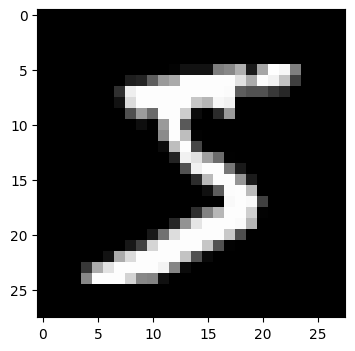

In [ ]:
# print some dataset properties
x0, y0 = train_data[0]
print(f"First image shape: {x0.shape}")
print(f"First image label: {y0}")
print(f"First image pixel mean: {torch.mean(x0):.3f}")
print(f"First image pixel standard deviation: {torch.std(x0):.3f}")

# plot the first image
fig = plt.figure(dpi=100, figsize=(4,4))
plt.imshow(x0.squeeze(), cmap="gray")
plt.show()

We see that each input is an image with $28\times 28$ pixels, i.e. $x_i\in\mathbb{R}^{28\times 28}$. Each of the pixels has a "brightness" value associated with it. This is because it represents a digtized image of a handwritten digit - each pixel's "brightness" corresponds to the presence of ink on the page. The truth labels just show you what number is in the image, in this case $y_0=5$. There are 60,000 train images and 10,000 test images. Let's plot a few more examples:

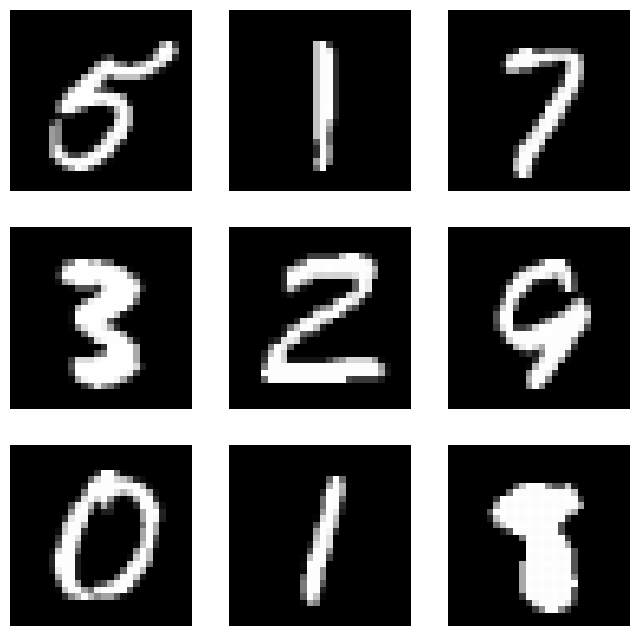

In [ ]:
# plot several random examples
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 2.1.1 Data Preparation

Now that we've taken some time to look at the data, let's use the default `MNIST DataLoaders` provided by `PyTorch`. We'll apply several transformations to the images. First, we'll ensure that they're stored as torch `tensor` objects, which you can think of as high-dimensional matrices that have gradients attached to them. Next, we'll normalize the data to have mean 0 and standard deviation 1 using the constants provided by `PyTorch`. Finally, we'll *flatten* the images into 28x28=784 dimensional arrays so that we can pass them into the NN.

In [ ]:
# imports
from torch.utils.data import DataLoader

In [ ]:
# let's flatten and normalize the data
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: torch.flatten(x))
])
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Let's look at the first image in the train set and check that it is now a vector of size $784$:

In [ ]:
# get the dimensions right - the original image was [1, 28, 28])
x0, y0 = train_data[0]
print(f"Image Shape: {x0.shape}")

Image Shape: torch.Size([784])


With our datasets in hand, `PyTorch` provides `DataLoader` classes designed to sample *batches* of data. Batching allows us to make predictions on several inputs at once before computing the gradients and using them to update the model. In this case, we pull a batch size of 128 images from the train set:

In [ ]:
# now let's build some data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

### 2.1.2 Training an NN
We've got our data, so now we need to build a model. We'll use the $ReLU(z)=\mathrm{max}(0,z)$ activation function and 2 hidden layers of size $128$. To do so, we're going to use the following `PyTorch` objects belonging to the `torch.nn` class:

- `Linear` creates weight and bias matrices populated with learnable parameters.
- `ReLU` implements the ReLU activation function.
- `Sequential` is a container for modules like `Linear` and `ReLU`. Once you have a `Sequential` object, it will apply all its modules in sequence, producing an output for you.


We're going to use these 3 ingredients in the cells below to create the following NN architecture:

\begin{align}
\text{Input}:&\qquad x_0\in\mathbb{R}^{784}\\
\text{1st Preactivations}:&\qquad  z_1 = W_1x_0 + b_1\\
\text{1st Hidden Layer}:&\qquad \sigma_1 = \mathrm{ReLU}(z_1)\\
\text{2nd Preactivations}:&\qquad z_2 = W_2\sigma_1+ b_2\\
\text{2nd Hidden Layer}:&\qquad \sigma_2=\mathrm{ReLU}(z_2)\\
\text{Output}:&\qquad W_3\sigma_2 + b_3\in\mathbb{R}^{10}
\end{align}

Our network is a function $f:\mathbb{R}^{784}\rightarrow\mathbb{R}^{10}$, i.e. its outputs will correspond to the probabilities that the 784 dimensional input is each digit between 0 and 9. Note that there's no output activation function because `PyTorch` will apply it for you.

In [ ]:
# imports
import time
from torch.nn import Sequential, Linear, ReLU, CrossEntropyLoss
from torch.optim import SGD

In [ ]:
model = Sequential(
    Linear(784, 128), # maps input_dim 784 to hidden_dim 128
    ReLU(), # 1st hidden layer has dimension 128
    Linear(128, 128), # maps hidden_dim 128 to hidden_dim 128
    ReLU(),  # 2nd hidden layer has dim 128
    Linear(128, 10) # maps hidden_dim 128 to output_dim 10
)

We'll ooptimize a cross entropy loss since we've got another multi-class classification problem.

In [ ]:
loss_fn = CrossEntropyLoss()

Previously, we applied gradient descent to train our network. We're going to do something similar here by applying *stochastic gradient descent* (SGD). Here, stochastic means that instead of calculating full gradients (which is expensive), we're going to estimate the gradients by randomly selecting subsets of data. The learning rate, or `lr` below, controls the speed of learning and needs to be carefully tuned in practice. We've also introduced another hyperparameter called `momentum`. In a nutshell, momentum means that the minimization experiences inertia when performing gradient descent - if a direction is consistently favorable, the optimization will begin to build speed in that direction. This is generally a good thing to do in practice, as you can "run past" noisy fluctuations or flat regions of the loss landscape.

In [ ]:
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.8)

Now we need to train our model. To do so, we're going to run a standard `PyTorch` train step repeatedly over all the training data. In practice, you'll usually grab a similar train function from the `PyTorch` documentation pages and then adapt it to your own needs. The train step has several key ingredients, which are heavily commented in the cell below.

In [ ]:
def train_step(model, train_loader, optimizer, loss_fn):
  # track the total loss and the number N of images processed
  total_loss, N = 0, 0

  # set the model in train mode, which tells PyTorch to track gradients
  model.train()

  # loop over batches of images (batch_size x 784) and labels (784)
  t0 = time.time()
  for data in train_loader:

    # unpack the data in the batch
    (images, labels) = data

    # zero out any gradients calculated during the last batch
    optimizer.zero_grad()

    # use the model to predict labels for each image
    y_pred = model(images)

    # calculate the cross entropy loss between the prediction and truth
    loss = loss_fn(y_pred, labels)

    # compute the gradients of the loss function
    loss.backward()

    # use the gradients to update the model's learnable parameters
    optimizer.step()

    # accumulate some statistics
    total_loss += loss.item()
    N+=len(labels)

  return total_loss/N, time.time()-t0

With our train step in hand, now we just need to run a training loop over several epochs:

In [ ]:
# training sequence
n_epochs = 10
for epoch in range(n_epochs):
  epoch_loss, epoch_time = train_step(model, train_loader, optimizer, loss_fn)
  print(f"Epoch {epoch}: loss={epoch_loss:.4f}, time={epoch_time:.4f}")

Epoch 0: loss=0.0057, time=13.8593
Epoch 1: loss=0.0022, time=14.2437
Epoch 2: loss=0.0018, time=13.3912
Epoch 3: loss=0.0015, time=13.4511
Epoch 4: loss=0.0013, time=13.4039
Epoch 5: loss=0.0012, time=13.5913
Epoch 6: loss=0.0010, time=13.4915
Epoch 7: loss=0.0009, time=13.7718
Epoch 8: loss=0.0008, time=13.4092
Epoch 9: loss=0.0008, time=13.9780


You should notice tha the loss steadiliy decreases from epoch to epoch. Each epoch should take about 10 seconds. If this feels slow, don't worry - we'll speed it up in subsequent cells. Now that our model has been trained, it's time to evaluate its performance. Ideally, we hope that it has learned to recognize images from the train set in a general way, i.e. that it hasn't just memorized the train data (this is called overfitting). To test the model's *generalization*, we will apply it to the sample of test data, which it has so far never seen. In doing so, we need to write a new test step. This will look similar to the train step, except now we're *not* going to calculate gradients or update the model's learnable parameters. We encode this explicitly by writing `model.eval()` and `with torch.no_grad()`.

In [ ]:
def test_step(model, test_loader, loss_fn):
  # statistics to accumulate
  total_loss, total_correct, N = 0, 0, 0

  # tell torch not to track gradients or update the model
  model.eval()
  with torch.no_grad():
    # loop over all batches in the test data
    for data in enumerate(test_loader):

      # unpack the batch of data
      idx, (images, labels) = data

      # calculate the model's prediction
      y_pred = model(images)

      # compute the loss and store relevant statistics
      loss = loss_fn(y_pred, labels)
      total_loss += loss.item()
      total_correct += sum(y_pred.argmax(1)==labels)
      N+=len(labels)

  return total_loss/N, total_correct/N

# evaluate the model
loss, acc = test_step(model, test_loader, loss_fn)
print("Test Set Performance:")
print(f"Average Loss: {loss:.3f}")
print(f"Classification Accuracy: {acc:.3f}")

Test Set Performance:
Average Loss: 0.001
Classification Accuracy: 0.969


Hey, 97% is pretty good considering we just treated the images as vectors, effectively disregarding any local spatial information inside of them. More complicated architectures like convolutional neural networks (CNNs) can leverage this localized information to make even better predictions on MNIST.

## 2.2 Faster Training

In [ ]:
from torchvision.datasets import MNIST

class FastMNIST(MNIST): # build our new class on top of the old one
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # flatten, re-scale, normalize the data
        self.data = self.data.unsqueeze(1).float().div(255)
        self.data = self.data.sub_(0.1307).div_(0.3081)
        self.data = self.data.view(len(self.data), 28*28)

        # load all the images and labels onto the GPU in advance
        self.data, self.targets = self.data.to(device), self.targets.to(device)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return (img, target)

# create our new FastMNIST dataset
train_data = FastMNIST("data", train=True, download=True)
test_data = FastMNIST("data", train=False, download=True)

# this works just like our last dataset except everything is now on a GPU
train_loader = DataLoader(train_data, batch_size=128, num_workers=0, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 148984846.43it/s]

Extracting data/FastMNIST/raw/train-images-idx3-ubyte.gz to data/FastMNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 61179643.35it/s]


Extracting data/FastMNIST/raw/train-labels-idx1-ubyte.gz to data/FastMNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49944330.96it/s]


Extracting data/FastMNIST/raw/t10k-images-idx3-ubyte.gz to data/FastMNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4974028.40it/s]


Extracting data/FastMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FastMNIST/raw



Let's start our training procedure over. Above, we have code for the `train_step` and `test_step`, so let's define a new model and train it again by minimizing `CrossEntropyLoss` with the `SGD` optimization algorithm. This time, you'll see that it trains *much* faster with each epoch taking around 1 second.

In [ ]:
model = Sequential(
    Linear(784, 128),
    ReLU(), # hidden layer has dimension 32
    Linear(128, 128),
    ReLU(),
    Linear(128, 10)
).to(device)

loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.8)

# training sequence
n_epochs = 10
for epoch in range(n_epochs):
  epoch_loss, epoch_time = train_step(model, train_loader, optimizer, loss_fn)
  print(f"Epoch {epoch}: loss={epoch_loss:.4f}, time={epoch_time:.4f}")

# evaluate the model
loss, acc = test_step(model, test_loader, loss_fn)
print("Test Set Performance:")
print(f"Average Loss: {loss:.3f}")
print(f"Classification Accuracy: {acc:.3f}")

Epoch 0: loss=0.0056, time=1.4525
Epoch 1: loss=0.0023, time=1.0214
Epoch 2: loss=0.0018, time=1.0421
Epoch 3: loss=0.0015, time=1.3504
Epoch 4: loss=0.0013, time=1.1499
Epoch 5: loss=0.0012, time=1.0096
Epoch 6: loss=0.0010, time=1.0152
Epoch 7: loss=0.0009, time=1.0225
Epoch 8: loss=0.0008, time=1.0067
Epoch 9: loss=0.0008, time=1.0165
Test Set Performance:
Average Loss: 0.001
Classification Accuracy: 0.968


**Exercise**: Now that our training is sped up, we spend a bit more time tuning our model and training scheme. So far, we've picked the hyperparameters (e.g. learning rate and momentum in the optimizer, batch size, the size of the hidden layers, the number of hidden layers) somewhat randomly. Try varying them a bit - how does the model performance change? Can you get a better classification accuracy?